In [150]:
]activate ../../../

  Activating project at `~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode`


In [154]:
using GLMakie

In [152]:
using Revise
includet("./base.jl")
using StatsBase

In [284]:
using CairoMakie

# No-space

In [98]:
N = 100
logKs = range(-0.5, 5, N)
lis = range(0., 1., N)
@time xx = run_explike_Kl_nospace(logKs, lis, 100000000000;
    save_sols=true,
    solver=QNDF(),
)
countmap(xx[1])

┌ Warning: At t=3.8813448794985767e6, dt was forced below floating point epsilon 4.656612873077393e-10, and step error estimate = 1.1255581043864076. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623


  2.434539 seconds (6.40 M allocations: 538.512 MiB, 11.83% gc time)


Dict{SciMLBase.ReturnCode.T, Int64} with 2 entries:
  Unstable => 1
  Success  => 9999

### Figuring out why parallelism does ont work...

In [704]:
function mm_run_explike_nospace1(mmp, u0, T;
    solver=QNDF(),
    dtmax=(T / 1000),
    kwargs...
)
    mmicrm_params = mmp_to_mmicrm(mmp)
    p = make_mmicrm_problem(mmicrm_params, copy(u0), T)
    s = solve(p, solver; dtmax, kwargs...)
end
function mm_run_explike_nospace2(mmp, u0, T;
    solver=QNDF(),
    kwargs...
)
    mmicrm_params = mmp_to_mmicrm(mmp)
    p = make_mmicrm_ss_problem(mmicrm_params, copy(u0))
    s = solve(p, DynamicSS(solver); kwargs...)
end

mm_run_explike_nospace2 (generic function with 1 method)

In [587]:
mmp = MMParams(;
    K=10 ^ 4.,
    m=1.,
    l=0.7,
    k=0.,
    c=1.,
    d=1.,
)
@time s = mm_run_explike_nospace1(mmp, [1., 0., 0.], 1e6;
    # dtmax=1e2
);
mmicrmmaxresid(s)

  0.004233 seconds (5.19 k allocations: 455.672 KiB)


5.4569682106375694e-12

In [776]:
function faf(N=100)
    u0 = [1., 0., 0.]
    for i in 1:N
        mmp = MMParams(;
            K=10 ^ 4.,
            m=1.,
            l=(1. / i),
            k=0.,
            c=1.,
            d=1.,
        )
        mmicrm_params = mmp_to_mmicrm(mmp)
        p = make_mmicrm_problem(mmicrm_params, copy(u0), 1e8)
        tol = 100 * eps()
        s = solve(p, QNDF();
            abstol=tol,
            reltol=tol,
            callback=make_timer_callback(2)
        )
        # @printf "% 8.3g -> % 10.5g\n" (1. / i) mmicrmmaxresid(s)
    end
end
function faf2(N=100)
    u0 = [1., 0., 0.]
    @threads for i in 1:N
        # @set ntasks = 20
        mmp = MMParams(;
            K=10 ^ 4.,
            m=1.,
            l=(1. / i),
            k=0.,
            c=1.,
            d=1.,
        )
        mmicrm_params = mmp_to_mmicrm(mmp)
        p = make_mmicrm_problem(mmicrm_params, copy(u0), 1e8)
        tol = 100 * eps()
        s = solve(p, QNDF();
            abstol=tol,
            reltol=tol,
            callback=make_timer_callback(2)
        )
        # @printf "% 8.3g -> % 10.5g\n" (1. / i) mmicrmmaxresid(s)
    end
end

faf2 (generic function with 2 methods)

In [778]:
@time faf()
@time faf2()

  0.605433 seconds (1.89 M allocations: 182.619 MiB)
  0.752253 seconds (1.89 M allocations: 182.638 MiB)


In [772]:
@benchmark faf(200)

BenchmarkTools.Trial: 5 samples with 1 evaluation per sample.
 Range (min … max):  1.082 s …   1.218 s  ┊ GC (min … max): 0.00% … 6.15%
 Time  (median):     1.117 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.129 s ± 51.921 ms  ┊ GC (mean ± σ):  1.33% ± 2.75%

  █          █  ██                                        █  
  █▁▁▁▁▁▁▁▁▁▁█▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.08 s         Histogram: frequency by time        1.22 s <

 Memory estimate: 362.26 MiB, allocs estimate: 3738442.

In [775]:
@benchmark faf2(200)

BenchmarkTools.Trial: 3 samples with 1 evaluation per sample.
 Range (min … max):  1.743 s …   1.818 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.779 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.780 s ± 37.216 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                          █                            █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.74 s         Histogram: frequency by time        1.82 s <

 Memory estimate: 362.27 MiB, allocs estimate: 3738567.

### Figuring out the large residuals
**Solution** - Turns out this is just the solver being too focused on speed, changing solver can change the issue, e.g. Euler will converge to a ss and the more advanced ones can be tuned to converge too. Good solutions:
- use dtmax with QNDF or TRBDF2
- use a steady state problem - I guess this does something similar on it's own? idk but works
- use an additional Euler run after

In [650]:
function analyze_sol(s)
    grads = mmicrmresid.(s.u, Ref(s.prob.p))
    maxgrads = mmicrmmaxresid.(s.u, Ref(s.prob.p))
    dts = s.t[2:end] .- s.t[1:end-1]
    dus = s.u[2:end] .- s.u[1:end-1]
    maxdus = maximum.(dus)

    (; grads, maxgrads, dts, dus, maxdus)
end
function kaka(s)
    xx = analyze_sol(s)
    
    fap = scatterlines(xx.maxgrads;
        axis=(;
            title="maxgrad",
            # xscale=log10,
            # yscale=log10,
        )
    )
    
    ax2 = Axis(fap.figure[2,1];
        title="dts",
        yscale=log10
    )
    linkxaxes!(fap.axis, ax2)
    scatterlines!(ax2, xx.dts)
    
    ax3 = Axis(fap.figure[3,1];
        title="dus",
        # yscale=log10
    )
    linkxaxes!(fap.axis, ax3)
    for i in 1:3
        scatterlines!(ax3, getindex.(xx.dus, i))
    end
    # ylims!(ax3, (-1., 1.) .* 1e-4)
    
    ax4 = Axis(fap.figure[0,1];
        title="grads",
        # yscale=log10
    )
    linkxaxes!(fap.axis, ax4)
    for i in 1:3
        scatterlines!(ax4, getindex.(xx.grads, i))
    end
    # for ax in (fap.axis, ax4)
    #     ylims!(ax, (-1., 1.) .* 5e-1)
    # end
    
    FigureAxisAnything(fap.figure, [fap.axis, ax2, ax3, ax4], nothing)
end

kaka (generic function with 1 method)

In [651]:
mmp = MMParams(;
    K=10 ^ 4.,
    m=1.,
    l=1.,
    k=0.,
    c=1.,
    d=1.,
)
mmicrm_params = mmp_to_mmicrm(mmp)
p = make_mmicrm_problem(mmicrm_params, [1., 0., 0.], 1e6)
@time s = solve(p, QNDF();
    dtmax=1e3
);

  0.001169 seconds (4.67 k allocations: 414.547 KiB)


In [652]:
u = s.u[end]
mmicrmmaxresid(u, mmicrm_params)

0.04117221184242226

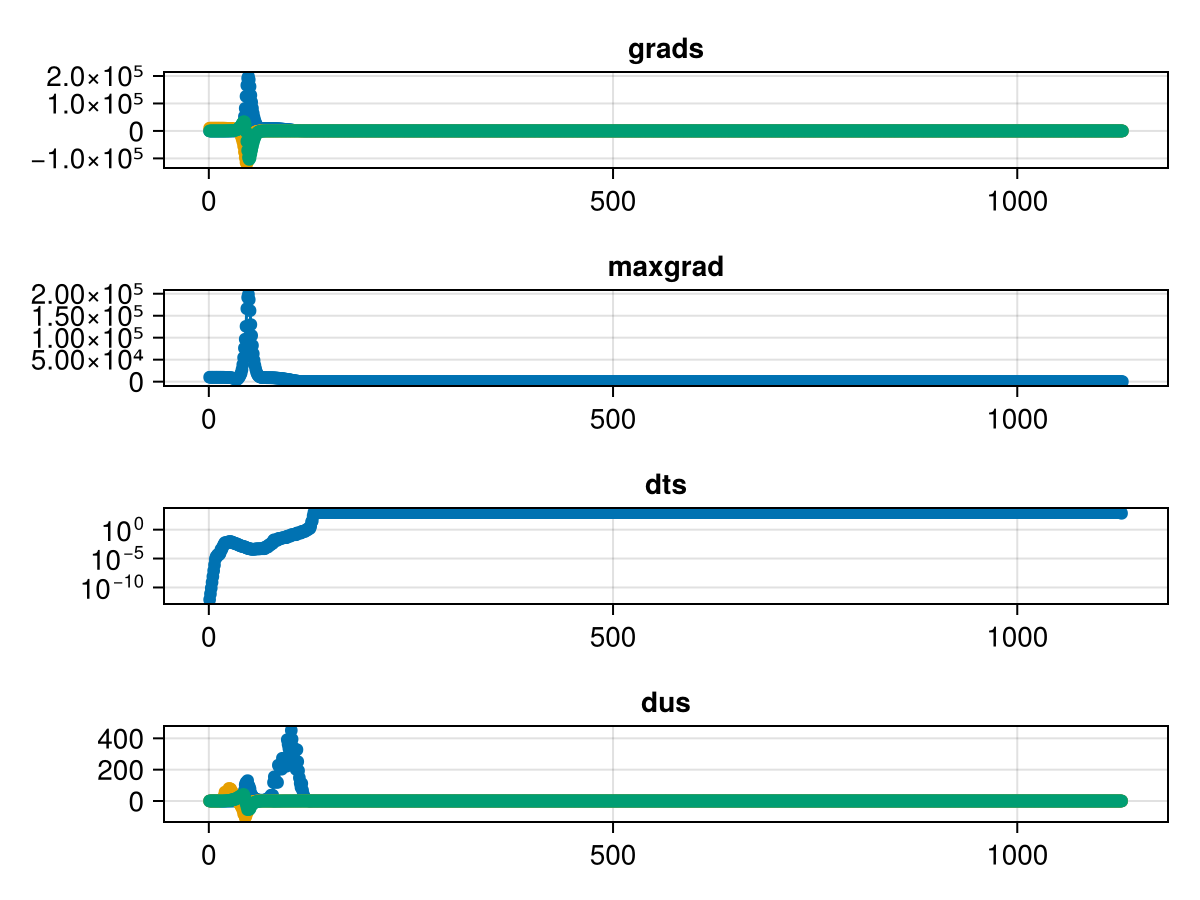

In [653]:
kaka(s)

In [654]:
s.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  2861
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    65
Number of linear solves:                           1711
Number of Jacobians created:                       6
Number of nonlinear solver iterations:             1661
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          1129
Number of rejected steps:                          14

In [528]:
xx = analyze_sol(s)
extrema(xx.dts)

(8.174053157485668e-13, 100000.00000000186)

steady state solver

In [699]:
ssp = make_mmicrm_ss_problem(mmicrm_params, [1., 0., 0.])
@time sss = solve(ssp, DynamicSS(TRBDF2());
    abstol=1e-9,
    reltol=1e-12,
    # reltol=eps(),
    callback=make_timer_callback(2.)
)

@show sss.retcode
mmicrmmaxresid(sss.u, mmicrm_params)

  0.003806 seconds (8.27 k allocations: 776.922 KiB)
sss.retcode = SciMLBase.ReturnCode.Success


1.4430012595904935e-10

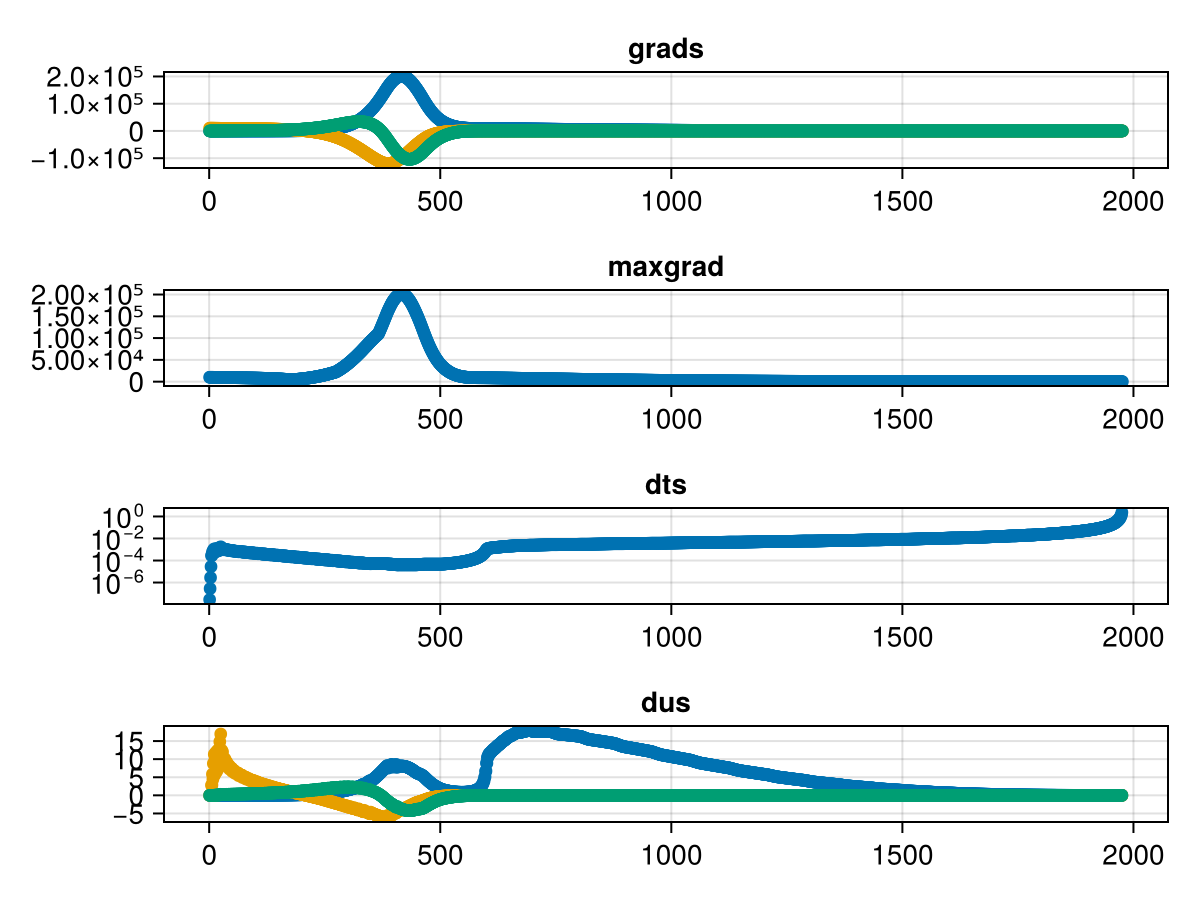

In [701]:
kaka(sss.original)

### Kaka

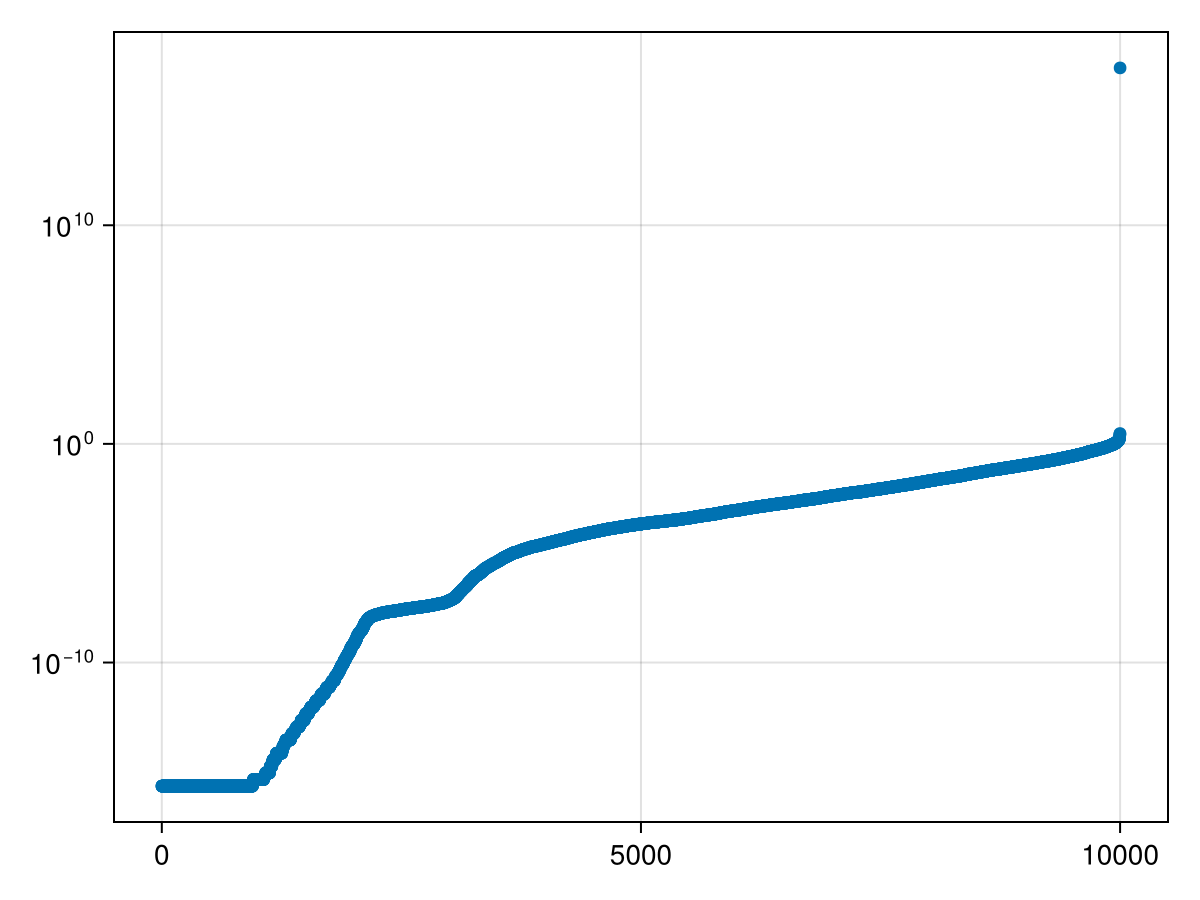

In [99]:
yy = getindex.(xx.final_states, 1)
yy = xx.maxresids
yy = clamp.(yy, max(minimum(abs, yy), eps()), Inf)
scatter(sort(yy[:]);
    axis=(;
        yscale=log10,
    )
)

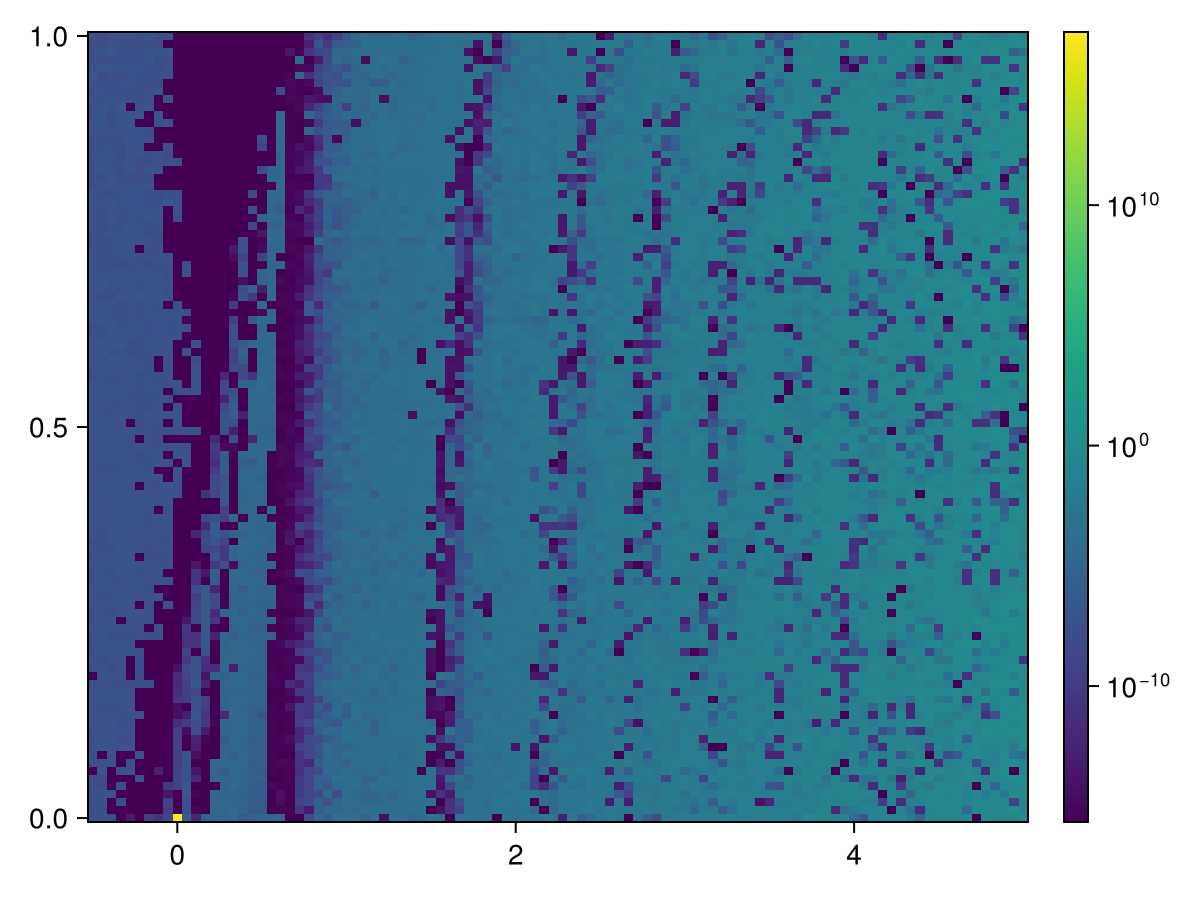

In [100]:
# yy = getindex.(xx.final_states, 3)
yy = xx.maxresids
fap = heatmap(logKs, lis, clamp.(yy, max(minimum(abs, yy), eps()), Inf);
    colorscale=log10,
# fap = heatmap(logKs, lis, yy;
    # colorrange=(1., 1.) .+ (-1., 1.) .* 0.9
)
Colorbar(fap.figure[1,2], fap.plot)
fap

# Space

In [31]:
N = 2
logKs = range(-0.5, 5, N)
lis = range(0., 1., N)
@time xx = run_explike_Kl_space(logKs, lis, 1000;
    solver=QNDF(),
    save_sols=true,
)
countmap(xx.retcodes)

 75.236273 seconds (2.44 M allocations: 6.562 GiB, 86.81% gc time, 0.25% compilation time)


Dict{SciMLBase.ReturnCode.T, Int64} with 1 entry:
  Success => 4

In [30]:
countmap(xx.retcodes)

Dict{SciMLBase.ReturnCode.T, Int64} with 1 entry:
  Success => 4

## Dealing with performance

In [841]:
using ProgressMeter

In [845]:
function gag(N=2)
    L = 2
    sN = 5000
    epsilon = 1e-5
    dx = L / (sN + 1)
    
    u0 = reduce(hcat, [[1., 0., 0.] .+ epsilon .* randn(3) for _ in 1:sN])

    iol = ReentrantLock()

    @tasks for l in range(0., 1., N)
        mmp = MMParams(;
            K=10 ^ 4.,
            m=1.,
            l=l,
            k=0.,
            c=1.,
            d=1.,
        )
        sps = SASMMiCRMParams(
            mmp_to_mmicrm(mmp),
            SA[1e-12, 1., 1.], 
            make_cartesianspace_smart(1; dx),
            # nthreads()
        )
        sp = make_smmicrm_problem(sps, copy(u0), 1e8)
        
        tol = 100 * eps()
        s = solve(sp, QNDF();
            abstol=tol,
            reltol=tol,
            callback=make_timer_callback(2)
        )
        # @show mmicrmmaxresid(s)
        lock(iol) do
            @printf "% 8.3g -> % 10.8g\n" l mmicrmmaxresid(s)
            # GC.gc()
        end
    end
end

@time gag(10)

       0 ->  9999.9997
   0.111 ->  9999.9968
   0.778 ->  9999.9937
   0.556 ->  9999.9982
   0.222 ->  9999.9848
       1 ->  9999.9924
   0.333 ->      10000
   0.889 ->  9999.9908
   0.667 ->  9999.9987
   0.444 ->      10000
  2.344020 seconds (2.76 M allocations: 4.724 GiB, 9.85% gc time, 9.63% compilation time)


## Testing

In [189]:
N = 100
logKs = range(-0.5, 5, N)
lis = range(0., 1., N)
@time xx = run_explike_Kl_nospace(logKs, lis, 10000000;
    save_sols=true
)
countmap(xx[1])

  3.646430 seconds (8.92 M allocations: 703.548 MiB, 1.64% gc time)


Dict{SciMLBase.ReturnCode.T, Int64} with 1 entry:
  Success => 10000

In [243]:
s = xx.sols[50,50];
s.u[end]

3-element Vector{Float64}:
 165.31362815996357
   1.0029839480997134
   0.4934416119426851

In [780]:
L = 2
sN = 10000
epsilon = 1e-5
dx = L / (sN + 1)

mmp = MMParams(;
    m=1.,
    K=10.,
    c=1.,
    d=1.,
    l=1.,
)
sps = SASMMiCRMParams(
    mmp_to_mmicrm(mmp),
    SA[1e-12, 1., 1.], 
    make_cartesianspace_smart(1; dx),
    nthreads()
)
u0 = reduce(hcat, [[1., 0., 0.] .+ epsilon .* randn(3) for _ in 1:sN])
sp = make_smmicrm_problem(sps, u0, 10000)

@time ss = solve(sp, TRBDF2());

  6.091102 seconds (309.94 k allocations: 3.974 GiB, 13.57% gc time)


In [310]:
sum(ss.u[end]; dims=2)[:,1]

3-element Vector{Float64}:
 77174.34089890757
 13023.18731739632
  9802.471783694742

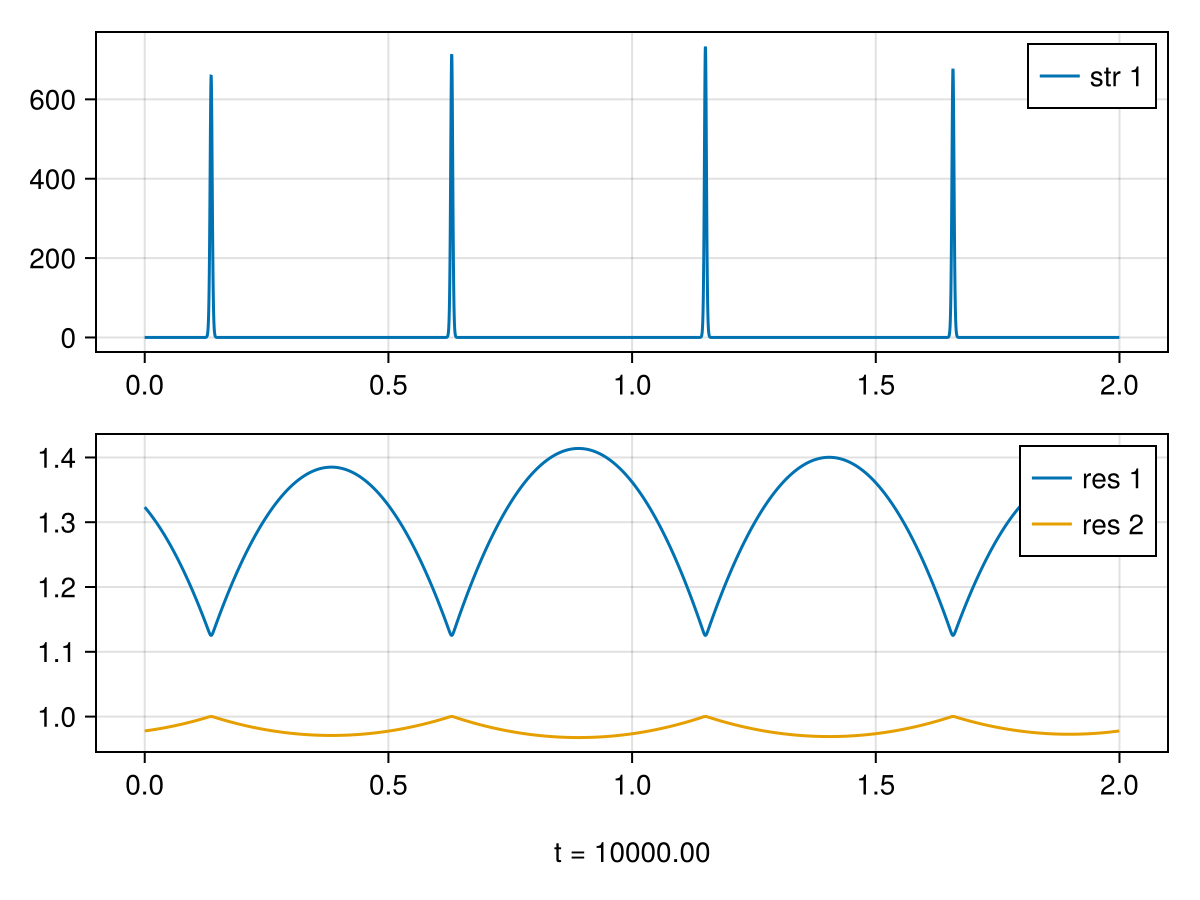

In [311]:
plot_1dsmmicrm_sol_snap(ss, -1)

# Testing

In [66]:
mmp = MMParams(;
    K=10 ^ 1.,
    m=1.,
    l=0.5,
    k=0.,
    c=1.,
    d=1.,
)
mmicrm_params = mmp_to_mmicrm(mmp)
p = make_mmicrm_problem(mmicrm_params, [1., 0., 0.], 10000000000)
s = solve(p, TRBDF2());
# p = make_mmicrm_ss_problem(mmicrm_params, copy(u0))
# s = solve(p, DynamicSS(solver); kwargs...)

In [93]:
mmicrmresid(s.u[end], s.prob.p)

3-element Vector{Float64}:
  4.540518929334589e-6
 -5.461991674948763e-6
  9.214727461070993e-7

In [69]:
check_mmicrmparams(mmicrm_params)

In [68]:
mmicrmfunc!()

mmicrmfunc! (generic function with 12 methods)

In [67]:
uninplace(mmicrmfunc!)()

#18 (generic function with 1 method)